In [1]:
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import yfinance as yf
from keras.layers import LSTM, GRU, Dense
from keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA

warnings.simplefilter("ignore")

tf.random.set_seed(455)
np.random.seed(455)

ticker = "AAPL"
end = datetime.now()
start = datetime(2016, end.month, end.day)
dataset = yf.download(ticker, start, end)
dataset

2023-07-20 12:07:08.559325: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-07-20,25.000000,25.115000,24.934999,24.990000,23.074883,105104000
2016-07-21,24.957500,25.250000,24.782499,24.857500,22.952530,130808000
2016-07-22,24.815001,24.825001,24.577499,24.665001,22.774778,113254800
2016-07-25,24.562500,24.709999,24.230000,24.334999,22.470074,161531600
2016-07-26,24.205000,24.492500,24.105000,24.167500,22.315407,224959200
...,...,...,...,...,...,...
2023-07-13,190.500000,191.190002,189.779999,190.539993,190.539993,41342300
2023-07-14,190.229996,191.179993,189.630005,190.690002,190.690002,41573900
2023-07-17,191.899994,194.320007,191.809998,193.990005,193.990005,50520200


In [2]:
# Preprocess the data
data = dataset['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


# Function to create sequences for LSTM and GRU models
def create_dataset(dataset, time_steps=1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        data_X.append(a)
        data_Y.append(dataset[i + time_steps, 0])
    return np.array(data_X), np.array(data_Y)


# Define sequence length
sequence_length = 20

# Create sequences for LSTM and GRU models
X_train, y_train = create_dataset(train_data, sequence_length)
X_test, y_test = create_dataset(test_data, sequence_length)

11/11 [==============================] - 0s 2ms/step
RMSE: 4.665810907561245
MAE: 3.909924687565984
R2: 0.9136240629921771


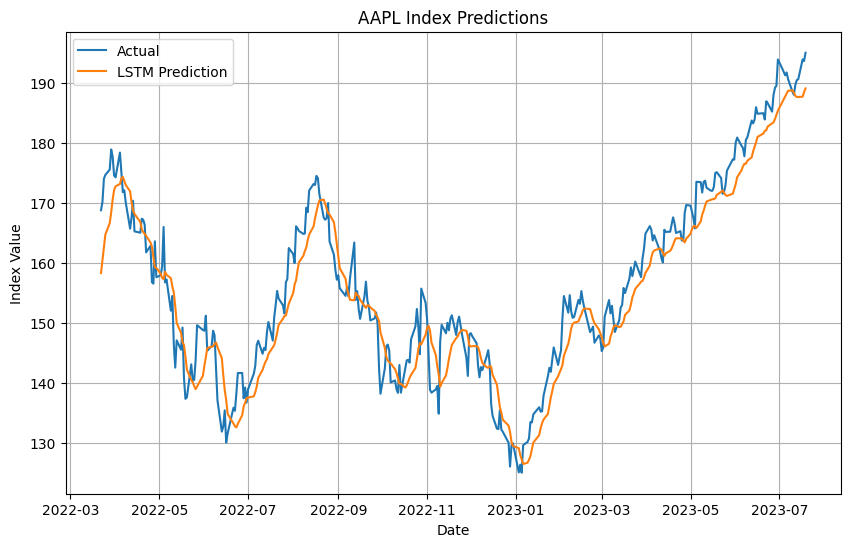

In [3]:
# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
lstm_model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=0)

# Generate predictions for the LSTM model
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Calculate indexes
lstm_rmse = np.sqrt(mean_squared_error(data[train_size + sequence_length:], lstm_predictions))
lstm_mae = mean_absolute_error(data[train_size + sequence_length:], lstm_predictions)
lstm_r2 = r2_score(data[train_size + sequence_length:], lstm_predictions)
print(f"RMSE: {lstm_rmse}")
print(f"MAE: {lstm_mae}")
print(f"R2: {lstm_r2}")

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(dataset.index[train_size + sequence_length:], data[train_size + sequence_length:], label='Actual')
plt.plot(dataset.index[train_size + sequence_length:], lstm_predictions, label='LSTM Prediction')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.title(f'{ticker} Index Predictions')
plt.legend()
plt.grid(True)
plt.show()

11/11 [==============================] - 0s 2ms/step
RMSE: 3.5627287009009923
MAE: 2.9036848051053985
R2: 0.9496378794374811


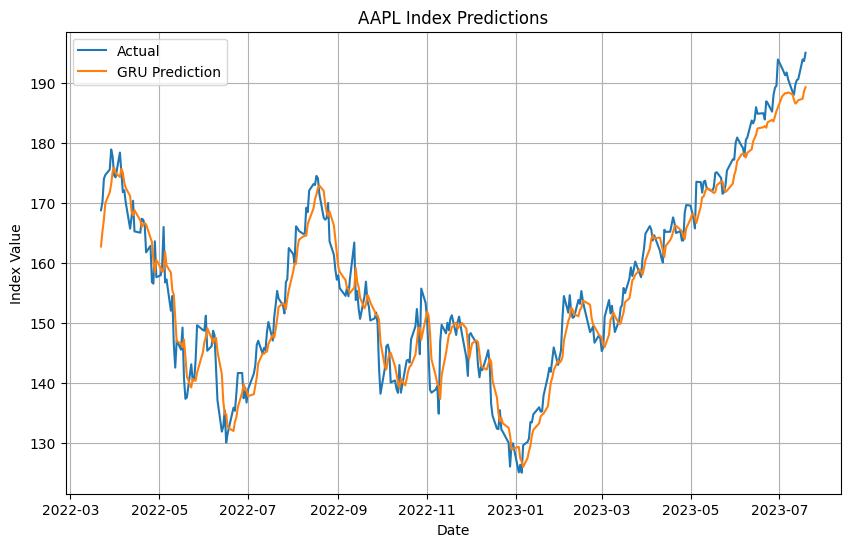

In [4]:
# Build the GRU model
gru_model = Sequential()
gru_model.add(GRU(50, activation='relu', input_shape=(sequence_length, 1)))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the GRU model
gru_model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=0)

# Generate predictions for the GRU model
gru_predictions = gru_model.predict(X_test)
gru_predictions = scaler.inverse_transform(gru_predictions)

# Calculate indexes
gru_rmse = np.sqrt(mean_squared_error(data[train_size + sequence_length:], gru_predictions))
gru_mae = mean_absolute_error(data[train_size + sequence_length:], gru_predictions)
gru_r2 = r2_score(data[train_size + sequence_length:], gru_predictions)
print(f"RMSE: {gru_rmse}")
print(f"MAE: {gru_mae}")
print(f"R2: {gru_r2}")

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(dataset.index[train_size + sequence_length:], data[train_size + sequence_length:], label='Actual')
plt.plot(dataset.index[train_size + sequence_length:], gru_predictions, label='GRU Prediction')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.title(f'{ticker} Index Predictions')
plt.legend()
plt.grid(True)
plt.show()

RMSE: 0.0222819561387548
MAE: 0.016994831537089174
R2: 0.939555986325972


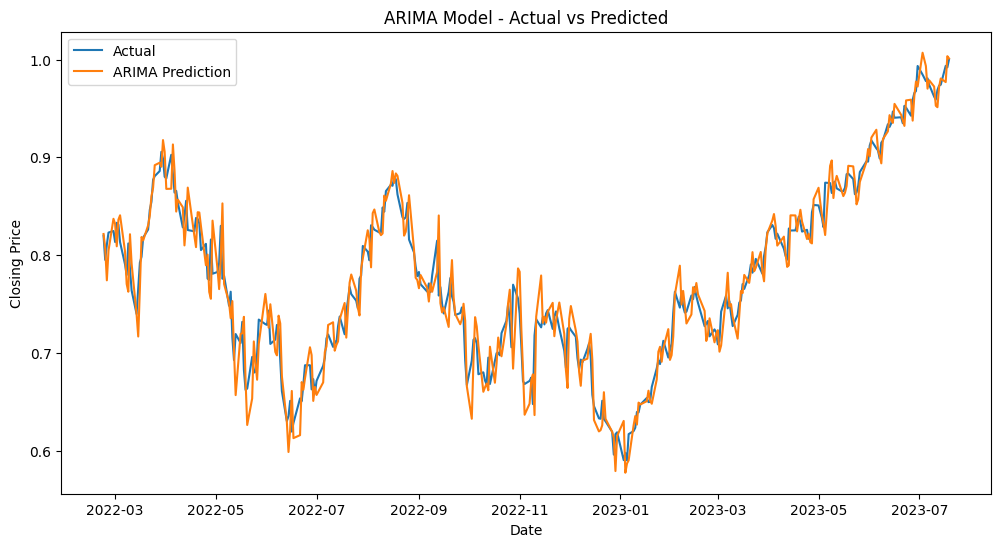

In [5]:
history = [x for x in train_data]
arima_predictions = []
for t in range(len(test_data)):
    model = ARIMA(history, order=(1, 2, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    arima_predictions.append(yhat)
    obs = test_data[t]
    history.append(obs)

# Calculate RMSE
arima_rmse = np.sqrt(mean_squared_error(test_data, arima_predictions))
arima_mae = mean_absolute_error(test_data, arima_predictions)
arima_r2 = r2_score(test_data, arima_predictions)
print(f"RMSE: {arima_rmse}")
print(f"MAE: {arima_mae}")
print(f"R2: {arima_r2}")

# Plot the actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(dataset.index[train_size:], test_data, label='Actual')
plt.plot(dataset.index[train_size:], arima_predictions, label='ARIMA Prediction')
plt.title('ARIMA Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()